## SI epidemic simulations: infection time vs distance

In [1]:
import networkx as nx
import EoN

import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

from tqdm.notebook import tqdm

In [2]:
TAU = 0.1
TMAX = 5.0

In [3]:
# Import Reddit Hyperlink network
edges = np.loadtxt('data/edges.csv', delimiter=',', dtype=int, skiprows=1)
G = nx.Graph()
G.add_edges_from(edges)

### Functions

In [4]:
def simulate_si(G: nx.Graph, tau: float, tmax: float, initial_infected: int, n_runs: int) -> dict[int, dict[str, float]]:
    """Simulates SI epidemic n_runs times on graph G with infection rate tau and initial infected node initial_infected. Returns a dictionary which contains, for each node, its distance from the initial infected node and its mean infection time."""

    # Compute shortest path lengths from initial_infected to all other nodes
    # `distances` contains all nodes that are reachable from initial_infected
    distances = nx.shortest_path_length(G, source=initial_infected)

    # Initialise dictionary to store distance and infection times for each node
    node_distance_time = {node: {'distance': distances[node], 'time': []} for node in distances}

    # Run SI simulation n_runs times
    for run in tqdm(range(n_runs)):
        sim = EoN.fast_SIR(G, tau, gamma=0, tmax=tmax, initial_infecteds=initial_infected, return_full_data=True)

        # Record infection time for each infected node
        for node in distances:
            if 'I' in (node_history := sim.node_history(node))[1]:
                node_distance_time[node]['time'].append(node_history[0][node_history[1].index('I')])
    
    # Filter out nodes that were never infected
    node_distance_time = {k: v for k, v in node_distance_time.items() if v['time']}

    # Compute mean infection time for each node
    for node in node_distance_time:
        node_distance_time[node]['time'] = np.mean(node_distance_time[node]['time'])

    # Print standard deviation of infection times
    print(f'Standard deviation of infection times: {np.std([v["time"] for v in node_distance_time.values()])}')

    return node_distance_time

In [5]:
def plot_distance_time(node_distance_time: dict[int, dict[str, float]], initial_infected_id: int, initial_infected_name: str, save=False) -> None:
    """Plots the mean infection time of each node as a function of its distance from the initial infected node."""

    # Create lists of distances and times
    distances = [node_distance_time[node]['distance'] for node in node_distance_time]
    times = [node_distance_time[node]['time'] for node in node_distance_time]

    # Plot time as a function of distance
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.scatter(distances, times, marker='x')
    ax.set_title(f"Initial infected node: {initial_infected_name} (id={initial_infected_id})")
    ax.set_xlabel('Distance from initial infected node')
    ax.set_ylabel('Mean infection time')

    # Add text box showing total infected nodes
    total_infected = len(node_distance_time)
    ax.text(0.04, 0.95, f"Total infected: {total_infected}",
            transform=ax.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Jank - manually set axis limits to emulate shared axis
    ax.set_xlim(-0.2, 5.2)
    ax.set_ylim(0 - (TMAX * 1.2) * 0.025, (TMAX * 1.2) * 1.025)
    
    # Save figure
    if save:
        fig.savefig(f"results/task2/{initial_infected_name.replace(' ', '_')}.png", dpi=fig.dpi, bbox_inches='tight')

    plt.show()

In [6]:
# Dictionary to store final results
centrality_node_distance_time = {}

## Eigenvector centrality

In [7]:
# Import node eigenvector centralities
with open('data/task2/eigenvector_centrality.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    node_eigenvector = {int(row[0]): float(row[1]) for row in reader}

In [8]:
# Find node with highest eigenvector centrality
max_eigenvector_node = max(node_eigenvector, key=node_eigenvector.get)
print(f"Max eigenvector node: {(max_eigenvector_node, node_eigenvector[max_eigenvector_node])}")

# Simulate SI epidemic with max eigenvector node as initial infected node
node_distance_time = simulate_si(G, tau=TAU, tmax=TMAX, initial_infected=max_eigenvector_node, n_runs=10)

# Store results
centrality_node_distance_time['max_eigenvector'] = node_distance_time
centrality_node_distance_time['max_eigenvector']['initial_infected'] = max_eigenvector_node

# Print total infected nodes
print(f"Total infected nodes: {len(node_distance_time)}")

# Plot mean infection time as a function of distance from initial infected node
# plot_distance_time(node_distance_time, max_eigenvector_node, 'max eigenvector', save=False)

Max eigenvector node: (59, 0.19980016082723698)


  0%|          | 0/10 [00:00<?, ?it/s]

Standard deviation of infection times: 0.8845010954273144
Total infected nodes: 33399


In [9]:
# Find node with lowest eigenvector centrality
min_eigenvector_node = min(node_eigenvector, key=node_eigenvector.get)
print(f"Min eigenvector node: {(min_eigenvector_node, node_eigenvector[min_eigenvector_node])}")

# Simulate SI epidemic with min eigenvector node as initial infected node
node_distance_time = simulate_si(G, tau=TAU, tmax=TMAX, initial_infected=min_eigenvector_node, n_runs=10)

# Store results
centrality_node_distance_time['min_eigenvector'] = node_distance_time
centrality_node_distance_time['min_eigenvector']['initial_infected'] = min_eigenvector_node

# Print total infected nodes
print(f"Total infected nodes: {len(node_distance_time)}")

# Plot mean infection time as a function of distance from initial infected node
# plot_distance_time(node_distance_time, min_eigenvector_node, 'min eigenvector', save=False)

Min eigenvector node: (858, 1.5684687372311454e-20)


  0%|          | 0/10 [00:00<?, ?it/s]

Standard deviation of infection times: 0.8173730337655132
Total infected nodes: 3


## Betweenness centrality

In [10]:
# Import node betweenness centralities
with open('data/task2/betweenness_centrality.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    node_betweenness = {int(row[0]): float(row[1]) for row in reader}

In [11]:
# Find node with highest betweenness centrality
max_betweenness_node = max(node_betweenness, key=node_betweenness.get)
print(f"Max betweenness node: {(max_betweenness_node, node_betweenness[max_betweenness_node])}")

# Simulate SI epidemic with max betweenness node as initial infected node
node_distance_time = simulate_si(G, tau=TAU, tmax=TMAX, initial_infected=max_betweenness_node, n_runs=10)

# Store results
centrality_node_distance_time['max_betweenness'] = node_distance_time
centrality_node_distance_time['max_betweenness']['initial_infected'] = max_betweenness_node

# Print total infected nodes
print(f"Total infected nodes: {len(node_distance_time)}")

# Plot mean infection time as a function of distance from initial infected node
# plot_distance_time(node_distance_time, max_betweenness_node, 'max betweenness', save=False)

Max betweenness node: (59, 0.11404735670207757)


  0%|          | 0/10 [00:00<?, ?it/s]

Standard deviation of infection times: 0.876995178018848
Total infected nodes: 33316


In [12]:
# Find node with lowest betweenness centrality
min_betweenness_node = min(node_betweenness, key=node_betweenness.get)
print(f"Min betweenness node: {(min_betweenness_node, node_betweenness[min_betweenness_node])}")

# Simulate SI epidemic with min betweenness node as initial infected node
node_distance_time = simulate_si(G, tau=TAU, tmax=TMAX, initial_infected=min_betweenness_node, n_runs=10)

# Store results
centrality_node_distance_time['min_betweenness'] = node_distance_time
centrality_node_distance_time['min_betweenness']['initial_infected'] = min_betweenness_node

# Print total infected nodes
print(f"Total infected nodes: {len(node_distance_time)}")

# Plot mean infection time as a function of distance from initial infected node
# plot_distance_time(node_distance_time, min_betweenness_node, 'min betweenness', save=False)

Min betweenness node: (12, 0.0)


  0%|          | 0/10 [00:00<?, ?it/s]

Standard deviation of infection times: 0.7868364499935604
Total infected nodes: 28368


## Closeness?

In [13]:
# # Import node closeness centralities
# with open('data/task2/closeness_centrality.csv', 'r') as f:
#     reader = csv.reader(f)
#     next(reader)
#     node_closeness = {int(row[0]): float(row[1]) for row in reader}

# # Find node with highest closeness centrality
# max_closeness_node = max(node_closeness, key=node_closeness.get)
# print(f"Max closeness node: {(max_closeness_node, node_closeness[max_closeness_node])}")

# # Simulate SI epidemic with max closeness node as initial infected node
# node_distance_time = simulate_si(G, tau=TAU, tmax=TMAX, initial_infected=max_closeness_node, n_runs=10)

# # Store results
# centrality_node_distance_time['max_closeness'] = node_distance_time
# centrality_node_distance_time['max_closeness']['initial_infected'] = max_closeness_node

# # Print total infected nodes
# print(f"Total infected nodes: {len(node_distance_time)}")

# # Plot mean infection time as a function of distance from initial infected node
# # plot_distance_time(node_distance_time, max_closeness_node, 'max closeness', save=False)

# # Find node with lowest closeness centrality
# min_closeness_node = min(node_closeness, key=node_closeness.get)
# print(f"Min closeness node: {(min_closeness_node, node_closeness[min_closeness_node])}")

# # Simulate SI epidemic with min closeness node as initial infected node
# node_distance_time = simulate_si(G, tau=TAU, tmax=TMAX, initial_infected=min_closeness_node, n_runs=10)

# # Store results
# centrality_node_distance_time['min_closeness'] = node_distance_time
# centrality_node_distance_time['min_closeness'].update({'initial_infected': min_closeness_node})

# # Print total infected nodes
# print(f"Total infected nodes: {len(node_distance_time)}")

# # Plot mean infection time as a function of distance from initial infected node
# # plot_distance_time(node_distance_time, min_closeness_node, 'min closeness', save=False)

### Combined results

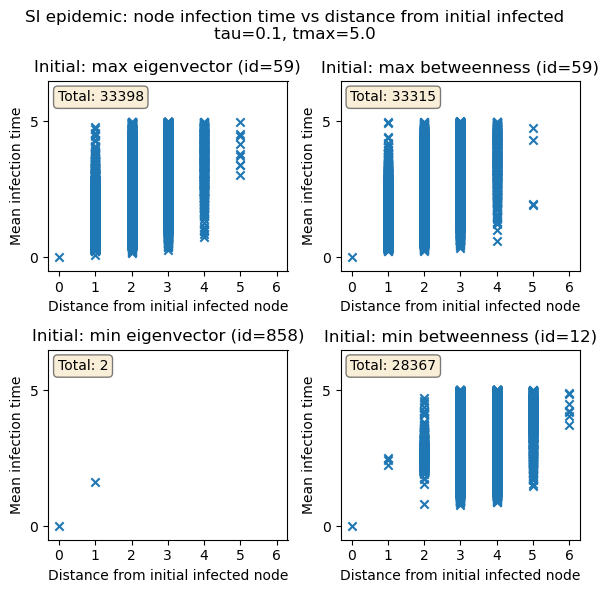

In [14]:
# Flatten final results
plot_data = {centrality: {'distance': [v['distance'] for v in node_distance_time.values() if type(v) == dict],
                          'time': [v['time'] for v in node_distance_time.values() if type(v) == dict],
                          'initial_infected': node_distance_time['initial_infected']}
             for centrality, node_distance_time in centrality_node_distance_time.items()}

# Combine results into a single figure
fig, axs = plt.subplots(len(plot_data) // 2, 2, figsize=(6, 2 + len(plot_data)), sharex=True, sharey=True)
fig.suptitle(f"SI epidemic: node infection time vs distance from initial infected\ntau={TAU}, tmax={TMAX}")

# Plot results
for i, (centrality, data) in enumerate(plot_data.items()):
    ax = axs[i % 2, i // 2]
    ax.set_title(f"Initial: {centrality.replace('_', ' ')} (id={data['initial_infected']})")
    ax.scatter(data['distance'], data['time'], marker='x')
    ax.set_xlabel('Distance from initial infected node')
    ax.set_ylabel('Mean infection time')

    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax.text(0.04, 0.95, f"Total: {len(data['distance'])}",
            transform=ax.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_ylim(0 - 0.1 * TMAX, TMAX + 0.3 * TMAX)
ax.set_yticks(np.arange(0, TMAX + 1, 5))
plt.tight_layout()

# Save figure
fig.savefig(f"results/task2/combined_tau{str(TAU).replace('.', '_')}_tmax{str(TMAX).replace('.', '_')}.png", dpi=fig.dpi, bbox_inches='tight')

plt.show()


In [15]:
# Import node degree centralities
with open('data/task2/degree_centrality.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    node_degree = {int(row[0]): float(row[1]) for row in reader}
    
# Find node with highest degree centrality
max_degree_node = max(node_degree, key=node_degree.get)
print(f"Max degree node: {(max_degree_node, node_degree[max_degree_node])}")

# Find node with lowest degree centrality
min_degree_node = min(node_degree, key=node_degree.get)
print(f"Min degree node: {(min_degree_node, node_degree[min_degree_node])}")

# Find node with highest betweenness centrality
max_betweenness_node = max(node_betweenness, key=node_betweenness.get)
print(f"Max betweenness node: {(max_betweenness_node, node_betweenness[max_betweenness_node])}")

# Find node with lowest betweenness centrality
min_betweenness_node = min(node_betweenness, key=node_betweenness.get)
print(f"Min betweenness node: {(min_betweenness_node, node_betweenness[min_betweenness_node])}")

# Import node closeness centralities
with open('data/task2/closeness_centrality.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    node_closeness = {int(row[0]): float(row[1]) for row in reader}

# Find node with highest closeness centrality
max_closeness_node = max(node_closeness, key=node_closeness.get)
print(f"Max closeness node: {(max_closeness_node, node_closeness[max_closeness_node])}")

# Find node with lowest closeness centrality
min_closeness_node = min(node_closeness, key=node_closeness.get)
print(f"Min closeness node: {(min_closeness_node, node_closeness[min_closeness_node])}")

# Find node with highest eigenvector centrality
max_eigenvector_node = max(node_eigenvector, key=node_eigenvector.get)
print(f"Max eigenvector node: {(max_eigenvector_node, node_eigenvector[max_eigenvector_node])}")

# Find node with lowest eigenvector centrality
min_eigenvector_node = min(node_eigenvector, key=node_eigenvector.get)
print(f"Min eigenvector node: {(min_eigenvector_node, node_eigenvector[min_eigenvector_node])}")

Max degree node: (59, 0.06529699510831585)
Min degree node: (46, 2.795248078266946e-05)
Max betweenness node: (59, 0.11404735670207757)
Min betweenness node: (12, 0.0)
Max closeness node: (59, 0.426222639576908)
Min closeness node: (858, 2.795248078266946e-05)
Max eigenvector node: (59, 0.19980016082723698)
Min eigenvector node: (858, 1.5684687372311454e-20)


In [16]:
# Print degree, betweenness, closeness and eigenvector centralities of node 12
print(f"Degree centrality: {node_degree[12]}")
print(f"Betweenness centrality: {node_betweenness[12]}")
print(f"Closeness centrality: {node_closeness[12]}")
print(f"Eigenvector centrality: {node_eigenvector[12]}")

Degree centrality: 8.385744234800838e-05
Betweenness centrality: 0.0
Closeness centrality: 0.2693748951964055
Eigenvector centrality: 0.0008471706371360171


In [19]:
# Rank of node 12 in eigenvector centrality
print(f"Rank of node 12 in eigenvector centrality: {sorted(node_eigenvector.values(), reverse=True).index(node_eigenvector[12]) + 1}")

# As a proportion of the total number of nodes
print(f"Proportion of nodes with higher eigenvector centrality: {sorted(node_eigenvector.values(), reverse=True).index(node_eigenvector[12]) / len(node_eigenvector)}")

# Rank of node 12 in closeness centrality
print(f"Rank of node 12 in closeness centrality: {sorted(node_closeness.values(), reverse=True).index(node_closeness[12]) + 1}")

# As a proportion of the total number of nodes
print(f"Proportion of nodes with higher closeness centrality: {sorted(node_closeness.values(), reverse=True).index(node_closeness[12]) / len(node_closeness)}")

# Rank of node 12 in degree centrality
print(f"Rank of node 12 in degree centrality: {sorted(node_degree.values(), reverse=True).index(node_degree[12]) + 1}")

# As a proportion of the total number of nodes
print(f"Proportion of nodes with higher degree centrality: {sorted(node_degree.values(), reverse=True).index(node_degree[12]) / len(node_degree)}")

Rank of node 12 in eigenvector centrality: 7811
Proportion of nodes with higher eigenvector centrality: 0.21830277280858676
Rank of node 12 in closeness centrality: 8623
Proportion of nodes with higher closeness centrality: 0.24099955277280857
Rank of node 12 in degree centrality: 8987
Proportion of nodes with higher degree centrality: 0.2511739713774597
